# City of Philadelphia Licenses and Inspections Appeals <a id='top'></a>

The dataset contains decisions of Philadelphia Licenses and Inspections Appeal Board. The dataset contains 28869 records and 37 columns.

Several columns such as Appeal Grounds, Related Permits and Proviso are in Natural Language format. 

Source: https://www.opendataphilly.org/dataset/license-and-inspections-appeals/resource/b721ad52-9e27-46d2-b494-6bf0ef1c7603?inner_span=True

### I would like to research the relationship of the board decision stored in the column 'decision' and other values in the dataset such as Appeal Grounds(NL), Related Permits(NL), Proviso(NL) and well as property address(geospatial).


## Table of Content

[Load and review the data](#Load-and-review-the-data)  
[Loading necessary packages](#Loading-necessary-packages)  
[Clear out Null values](#Clear-out-Null-values)  
[Remove /PROV value from decision column and store it as a flag in a separate field](#Remove-/PROV-value-from-decision-column-and-store-it-as-a-flag-in-a-separate-field)  
[Translate appeal decision into new feature and reduce the number of outcomes](#Translate-appeal-decision-into-new-feature-and-reduce-the-number-of-outcomes)  
[Dataset Centroids and distances from them](#Dataset-Centroids-and-distances-from-them)  
[Distances from Landmarks](#Distances-from-Landmarks)  
[Scatter Plot Map](#Scatter-Plot-Map)  
[Appeal Grounds](#Appeal-Grounds)  
[myMetrics Function for model testing](#myMetrics-Function-for-model-testing)  
[Pre-processing and Test/Train Split](#Pre-processing-and-Test/Train-Split)  
[Final Hypertable](#Final-Hypertable)  
[Testing Models with TFIDF classifier results](#Testing-Models-with-TFIDF-classifier-results)

### Loading necessary packages  <a id='Loading-necessary-packages'></a>

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
from pandas_profiling import ProfileReport
import string

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics #metrics module

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

hypertable=[]

### Load and review the data <a id='Load-and-review-the-data'></a> 
[(back to the top)](#top)

In [2]:
#Database URL
url = 'https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+appeals&filename=appeals&format=csv&skipfields=cartodb_id'
#Initial Dataset load
df = pd.read_csv(url, low_memory=False)

In [3]:
#Sample data
df.head()

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
0,0101000020E6100000C52903E74FCA52C09311DCA62FF9...,0101000020110F000038CC9C97CCEA5FC1A427E8645888...,3,547064.0,1201 SPRUCE ST,NaN,NaN,19107-5603,881517950.0,221809,...,2009-10-21 14:00:00,GRANTED/PROV,NaN,**Proviso - as per plans stamped by the Board ...,2009-10-21 00:00:00,HANSEN,2.694264e+06,234104.314141,39.946767,-75.161127
1,0101000020E61000001AD60399BDC852C057703BC5E5FC...,0101000020110F000025FCBC3C21E85FC182A76B2D758C...,4,754561.0,150 CECIL B MOORE AVE,NaN,NaN,19122-0000,183013005.0,540264,...,2009-10-21 14:00:00,GRANTED,NaN,NaN,2009-11-17 00:00:00,HANSEN,2.700833e+06,244864.919870,39.975762,-75.136572
2,0101000020E6100000A0845553CFCA52C0E5DA9A6577F9...,0101000020110F000040ED8208A5EB5FC1270846E0A788...,5,397995.0,1629 LOCUST ST,NaN,NaN,19103-6304,883046300.0,232156,...,2009-12-15 13:15:00,WITHDRAWN,NaN,NaN,2009-12-16 00:00:00,HANSEN,2.692061e+06,234837.744408,39.948956,-75.168904
3,0101000020E6100000DA7B120E01CA52C0F0294B399D05...,0101000020110F00009CE075A946EA5FC159D7E1811F96...,6,448281.0,2109-11 W NEDRO AVE,NaN,NaN,19138-2941,871091350.0,451808,...,2010-05-18 13:15:00,AFFIRMED,NaN,CITY WILL STAY ENFORCEMENT ACTION FOR 90 DAYS.,2010-05-18 00:00:00,HANSEN,2.694574e+06,269498.251054,40.043861,-75.156314
4,0101000020E6100000794B1B6210CA52C006AD0DFF1CFA...,0101000020110F0000E2E9D3B260EA5FC1FC79CE575F89...,7,19244.0,1023 ARCH ST,NaN,NaN,19107-2307,871402750.0,340135,...,2010-01-12 13:15:00,MOOT,NaN,COMPLIED,2010-01-13 00:00:00,HANSEN,2.695273e+06,236773.622501,39.954010,-75.157250


In [4]:
#Number of rows and features
print("df.shape", df.shape)

df.shape (29822, 37)


In [5]:
#Column Names
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng'],
      dtype='object')

In [6]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29822 entries, 0 to 29821
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              29221 non-null  object 
 1   the_geom_webmercator  29221 non-null  object 
 2   objectid              29822 non-null  int64  
 3   addressobjectid       29246 non-null  float64
 4   address               29245 non-null  object 
 5   unit_type             105 non-null    object 
 6   unit_num              558 non-null    object 
 7   zip                   29245 non-null  object 
 8   opa_account_num       28093 non-null  float64
 9   parcel_id_num         28575 non-null  object 
 10  censustract           29221 non-null  float64
 11  opa_owner             28766 non-null  object 
 12  primaryappellant      29822 non-null  object 
 13  appellanttype         29043 non-null  object 
 14  internaljobid         27715 non-null  float64
 15  appealnumber       

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

### Clear out Null values <a id='Clear-out-Null-values'></a>
[(back to the top)](#top)

I am dropping records with Null value in Decision column. They represent less than 10% of the data. With the multitude of unique values in that column I can't decide what value I can replace it with.

In [7]:
df = df[~df['decision'].isna()]
df[df['systemofrecord'].isna()]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [8]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

In [9]:
df[df['lat'].isna()].shape[0]

14

I'm dropping these as well.

In [10]:
df = df[~df['lat'].isna()]

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

In [11]:
#Percent of unique values per values per column
df.nunique()/df.shape[0]

the_geom                0.801214
the_geom_webmercator    0.801214
objectid                1.000000
addressobjectid         0.816519
address                 0.804599
unit_type               0.000184
unit_num                0.004305
zip                     0.486240
opa_account_num         0.775276
parcel_id_num           0.771781
censustract             0.014054
opa_owner               0.705997
primaryappellant        0.457138
appellanttype           0.000294
internaljobid           0.970971
appealnumber            1.000000
acceleratedappeal       0.000074
createddate             0.998602
completeddate           0.447792
relatedpermit           0.980721
relatedcasefile         0.000294
appealstatus            0.000294
appealtype              0.000478
agendadescription       0.000074
applicationtype         0.000258
meetingnumber           0.029029
appealgrounds           0.922848
scheduleddate           0.174099
decision                0.001177
meetingresult           0.000184
proviso   

In [12]:
df.dtypes

the_geom                 object
the_geom_webmercator     object
objectid                  int64
addressobjectid         float64
address                  object
unit_type                object
unit_num                 object
zip                      object
opa_account_num         float64
parcel_id_num            object
censustract             float64
opa_owner                object
primaryappellant         object
appellanttype            object
internaljobid           float64
appealnumber             object
acceleratedappeal        object
createddate              object
completeddate            object
relatedpermit            object
relatedcasefile          object
appealstatus             object
appealtype               object
agendadescription        object
applicationtype          object
meetingnumber            object
appealgrounds            object
scheduleddate            object
decision                 object
meetingresult            object
proviso                  object
decision

Clean Data Types

In [13]:
df['createddate'] = pd.to_datetime(df['createddate'])

In [14]:
df['completeddate'] = pd.to_datetime(df['completeddate'])
df['scheduleddate'] = pd.to_datetime(df['scheduleddate'])
df['decisiondate'] = pd.to_datetime(df['decisiondate'])

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

#### Cleaning  Application Type column

In [15]:
#Top examples of "applicationtype"
df['applicationtype'].value_counts().head(10)

RB_ZBA                         19042
RB_LIRB                         5587
RB_BBS                          1762
Zoning Board of Adjustment       742
Board of Building Standards       42
Plumbing Advisory Board            4
L&I Review Board Codes             1
Name: applicationtype, dtype: int64

Instead of using abbreviated values for Application Types lets rename them in fully spelled values

In [16]:
df['applicationtype'][df['applicationtype'] == 'RB_ZBA'] = 'Zoning Board of Adjustment'
df['applicationtype'][df['applicationtype'] == 'RB_LIRB'] = 'L&I Review Board Codes'
df['applicationtype'][df['applicationtype'] == 'RB_BBS'] = 'Board of Building Standards'

In [17]:
#Top examples of "appealgrounds"
df['applicationtype'].value_counts().head(10)

Zoning Board of Adjustment     19784
L&I Review Board Codes          5588
Board of Building Standards     1804
Plumbing Advisory Board            4
Name: applicationtype, dtype: int64

Lets drop Plumbing Advisory Board records as an outlier 

In [18]:
df = df[~(df['applicationtype'] == 'Plumbing Advisory Board')]

In [19]:
#Top examples of "appealgrounds"
df['applicationtype'].value_counts().head(10)

Zoning Board of Adjustment     19784
L&I Review Board Codes          5588
Board of Building Standards     1804
Name: applicationtype, dtype: int64

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

##### New Lawyer column showing if the owner is represented by a lawyer

In [20]:
df['primaryappellant'].value_counts().head(30)

SHAWN D. WARD, ESQUIRE          421
ZHEN JIN                        287
JOSEPH BELLER, ESQ.             254
DAVID ORPHANIDES, ESQ.          238
SHAWN WARD, ESQ.                228
RONALD PATTERSON, ESQ.          225
ALAN NOCHUMSON, ESQ.            198
RUSTIN OHLER                    182
BEDITZA CADILLO                 170
BRETT D. FELDMAN, ESQUIRE       165
VERN ANASTASIO, ESQ             162
STEPHEN G. POLLOCK, ESQUIRE     158
CARL PRIMAVERA, ESQUIRE         150
LEO MULVIHILL, JR., ESQ.        147
HENRY M. CLINTON, ESQ           143
DAVID G. ORPHANIDES, ESQUIRE    132
JOSEPH BELLER, ESQUIRE          131
ZHEN H. JIN, ESQ                114
RICHARD DEMARCO, ESQ.           113
HAROLD MURRAY                   110
JOSEPH BELLER, ESQ              110
MICHAEL MATTIONI                103
ZHEN H. JIN, ESQUIRE             96
ADAM E. LAVER, ESQUIRE           95
DARWIN R. BEAUVAIS, ESQUIRE      94
RONALD J. PATTERSON, ESQ         91
NEIL SKLAROFF, ESQUIRE           87
THOMAS CITRO                

In [21]:
df['primaryappellant'] = df['primaryappellant'].str.lower()
df['primaryappellant'] = df['primaryappellant'].str.replace(f'[{string.punctuation}]', '')
df['primaryappellant'].fillna('',inplace=True)

In [22]:
df['primaryappellant'] = df['primaryappellant'].apply(word_tokenize)

In [23]:
df['primaryappellant'].head(10)

0             [reed, d, lyons, esquire]
1             [jeffery, spann, esquire]
2                   [lisa, worthington]
3                       [nixon, losier]
4                        [my, my, tang]
5    [imperial, manor, ii, condominium]
6                 [paul, boni, esquire]
7              [steven, n, cherry, esq]
8             [joseph, beller, esquire]
9                      [anna, l, grant]
Name: primaryappellant, dtype: object

It's clear that the top names must be the names of lawyers representing their clients, but without having an ESQ or ESQUIRE suffix, I can't tell for sure.

In [24]:
#Create new column showing that the Owner is represented by a lawyer 

def lawyer(appellant):
    if 'esq' in appellant or 'esquire' in appellant:
        return 1
    else:
        return 0
df['lawyer'] = df['primaryappellant'].apply(lawyer)


In [25]:
df[['primaryappellant', 'lawyer']].head(10)

,primaryappellant,lawyer
0,"[reed, d, lyons, esquire]",1
1,"[jeffery, spann, esquire]",1
2,"[lisa, worthington]",0
3,"[nixon, losier]",0
4,"[my, my, tang]",0
5,"[imperial, manor, ii, condominium]",0
6,"[paul, boni, esquire]",1
7,"[steven, n, cherry, esq]",1
8,"[joseph, beller, esquire]",1
9,"[anna, l, grant]",0


&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

In [26]:
#Top examples of "appealgrounds"
df['appealgrounds'].value_counts().head(20)

PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                                                                                         111
PERMIT FOR A TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                                                                                        65
WE ARE APPEALING THE ISSUANCE OF BUILDING PERMIT #765070 FOR HEALTH AND ENVIRONMENTAL CONCERNS.                                                                                                                                                                                                       63
PERMIT FOR THREE (3) FAMILY DWELLING (MULTI-FAMILY DWELLING) IN AN EXISTING STRUCTURE.                       

In [27]:
pd.Series(df['relatedpermit'].value_counts().head(5).index.values).str.split("\n", expand=True).stack()

0  0            Description of Project:  SM/LRG FOOD ESTAB
   1                                      APPEAL TYPES==> 
   2                             APPEAL TYPE: LI-REFGRNT  
   3                                                      
   4                                   BOARD DECISIONS==> 
   5     DECISION: CONTINUED  DECDATE: 16-OCT-18  PROVI...
   6                                                      
   7                                     COURT APPEALS==> 
   8                                                      
1  0      Description of Project:  BUILDING PERMIT #765070
   1                                      APPEAL TYPES==> 
   2                             APPEAL TYPE: AGAINSTL&I  
   3                                                      
   4                                   BOARD DECISIONS==> 
   5     DECISION: AFFIRMED  DECDATE: 28-JUL-17  PROVIS...
   6                                                      
   7                                     COURT APPEALS==

In [28]:
#Top value of "proviso"
df['proviso'].value_counts().head(10)

COMPLIED                                                          1751
FOR WANT OF APPEARANCE                                             737
*****CASE WITHDRAWN.*****                                          402
*****CASE DISMISSED.*****                                          163
*****CASE DISMISSED - PUT INTO ENFORCEMENT.*****                   109
60 DAY STAY OF ENFORCEMENT                                         101
90 DAY STAY OF ENFORCEMENT                                          85
30 DAY STAY OF ENFORCEMENT                                          58
WITHOUT PREJUDICE;  CITY HAS THE RIGHT TO RE-ISSUE VIOLATIONS.      54
120 DAY STAY OF ENFORCEMENT                                         53
Name: proviso, dtype: int64

#### Cleaning Decision column

In [29]:
#Breakdown by decision
df['decision'].value_counts()

GRANTED         8436
GRANTED/PROV    6260
WITHDRAWN       2420
MOOT            2283
AFFIRMED        1956
DENIED          1796
APPROVED        1554
DISMISSED        936
Granted          594
SUSTAINED        255
CONTINUED        224
Withdrawn         89
DENIED/PROV       69
ADMIN/REVIEW      63
DISMI/ENFORC      42
Denied            40
Approved          39
REMAND            38
HELD              17
Dismissed         12
NEWHEARNOT        12
Refused           10
HELD/INFO          9
BOARDAKNOWL        7
LATE-APPRVD        3
REFUSED            3
NEWHEARYES         2
LATE-DENIED        2
REVISED            2
RESCHEDULE         1
Revised            1
ISSUED             1
Name: decision, dtype: int64

In [30]:
# Save the values
df['decisionsv']=df['decision']

In [31]:
df[(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == True)][['decision', 'proviso']]

,decision,proviso
3620,DENIED/PROV,NaN
25752,GRANTED/PROV,NaN


Even though there are only two records, it appears that /PROV in the 'decision' field doesn't mean that there is value in the field 'proviso'

In [32]:
df[~(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == False)][['decision', 'proviso']]

,decision,proviso
3,AFFIRMED,CITY WILL STAY ENFORCEMENT ACTION FOR 90 DAYS.
4,MOOT,COMPLIED
5,MOOT,COMPLIED
7,MOOT,COMPLIED
19,AFFIRMED,CITY WILL STAY ENFORCEMENT FOR 60 DAYS TO SECU...
...,...,...
29707,Granted,"With proviso: Revised plans, 1 page, approved ..."
29758,Granted,MAXIMUM 17 UNITS
29776,Granted,"With proviso: Revised plans, 2 pages, approved..."
29777,Granted,With proviso: Commercial trash pickup.


not having /PROV in 'decision' field doesn't mean no value in 'provision'

#### Remove /PROV value from decision column and store it as a flag in a separate field
[(back to the top)](#top)

In [33]:
# Add new field prvFlag to store "/PROV" from decision
df['provFlag'] = (df['decision'].str.contains('/PROV') == True).astype('int')

In [34]:
df[df['decision'].str.contains('/PROV')]['decision'].str.len().unique()

array([12, 11], dtype=int64)

In [35]:
def stripProviso (decision):
    if '/PROV' in decision:
        strLength = len(decision)
        return decision[0: strLength-5]
    else:
        return decision

In [36]:
df['decision'] = df['decision'].apply(stripProviso)

In [37]:
df[['decision','decisionsv','provFlag']]

,decision,decisionsv,provFlag
0,GRANTED,GRANTED/PROV,1
1,GRANTED,GRANTED,0
2,WITHDRAWN,WITHDRAWN,0
3,AFFIRMED,AFFIRMED,0
4,MOOT,MOOT,0
...,...,...,...
29781,Denied,Denied,0
29792,Granted,Granted,0
29796,Granted,Granted,0
29810,Granted,Granted,0


### Change case for all decisions to lower case

In [38]:
df['decision'] = df['decision'].str.lower()

### Combine dismissed and withdrawn as dismissed

In [39]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismi/enforc', 'dismissed']

In [40]:
def dismissed (decision):
    if 'dismi' in decision or decision == 'withdrawn':
        return 'dismissed'
    else:
        return decision

In [41]:
df['decision'] = df['decision'].apply(dismissed)

In [42]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismissed']

In [43]:
sorted(df['decision'].unique())

['admin/review',
 'affirmed',
 'approved',
 'boardaknowl',
 'continued',
 'denied',
 'dismissed',
 'granted',
 'held',
 'held/info',
 'issued',
 'late-apprvd',
 'late-denied',
 'moot',
 'newhearnot',
 'newhearyes',
 'refused',
 'remand',
 'reschedule',
 'revised',
 'sustained']

In [44]:
df['decision'].value_counts()

granted         15290
dismissed        3499
moot             2283
affirmed         1956
denied           1905
approved         1593
sustained         255
continued         224
admin/review       63
remand             38
held               17
refused            13
newhearnot         12
held/info           9
boardaknowl         7
late-apprvd         3
revised             3
late-denied         2
newhearyes          2
reschedule          1
issued              1
Name: decision, dtype: int64

In [45]:
df[(df['decision'] == 'complete')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

In [46]:
df[(df['decision'] == 'continued')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
### Reduce the number of decision choices
[(back to the top)](#top)

In [47]:
def translateComplete(meetingresult):
    switcher = {
        'Granted':'approved',
        'Denied':'denied',
        'Withdrawn':'other',
        'Dismissed':'denied',
        'Approved':'approved',
        'Refused':'denied'                
        }
    return switcher.get(meetingresult, 'other') 

#def CompleteDecision(decision, meetingresult):
def CompleteDecision(arg):
    if arg[0] == 'complete':
        return translateComplete(arg[1])
    else:
        return arg[0]

    
def funcNewDecision(decision): 
    switcher = {
        'admin/review': 'other',
        'affirmed':'denied',
        'approved':'approved',
        'boardaknowl':'other',
        'cancelled':'other',
        'complete':'complete',
        'continued':'other',
        'denied':'denied',
        'dismissed':'other',
        'granted':'approved',
        'held':'denied',
        'held/info':'denied',
        'issued':'other',
        'late-apprvd':'other',
        'late-denied':'other',
        'moot':'other',
        'newhearnot':'other',
        'newhearyes':'other',
        'refused':'denied',
        'remand':'other',
        'reschedule':'other',
        'rescheduled':'other',
        'revised':'other',
        'sustained':'denied'
        } 
    return switcher.get(decision, 'other') 

df['decision'].apply(funcNewDecision).value_counts()

df[df['decision'] == 'complete']['meetingresult'].apply(translateComplete).value_counts()

df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()

#df['newDecision'] = df[df['decision'] == 'complete'][['newDecision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()


granted         15290
dismissed        3499
moot             2283
affirmed         1956
denied           1905
approved         1593
sustained         255
continued         224
admin/review       63
remand             38
held               17
refused            13
newhearnot         12
held/info           9
boardaknowl         7
late-apprvd         3
revised             3
late-denied         2
newhearyes          2
reschedule          1
issued              1
dtype: int64

In [48]:
df['decision'] = df['decision'].apply(funcNewDecision)
df['decision'] = df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision)
df['decision'].value_counts()

approved    16883
other        6138
denied       4155
Name: decision, dtype: int64

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

In [49]:
pd.set_option('display.max_colwidth', None)
df[df['decisionsv'] == 'HELD/INFO'].head(5)

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
4077,0101000020E6100000CCF7447DB4CD52C0B3F0B9DC37F84340,0101000020110F0000B4D87CF98FF05FC10B2C36E745875241,3715,622915.0,5000-40 WOODLAND AVE,NaN,NaN,19143-5100,773182100.0,145910,...,FOR TAX CERT,2011-04-13,HANSEN,2.679485e+06,230919.547094,39.939205,-75.214141,1,HELD/INFO,0
6979,0101000020E61000000BDC3CA74DCA52C06FEFAEB9B0034440,0101000020110F000051F299C5C8EA5FC1D48F1C31FD935241,6818,398758.0,34 E LOGAN ST,NaN,NaN,19144-3017,121004500.0,343791,...,VOTE IN 2 WEEKS; APPLICANT & COMMUNITY TO MEET RE: PARKING ISSUES; LETTER TO ZBA 2 WEEKS,2008-08-19,HANSEN,2.693426e+06,263987.075341,40.028831,-75.160990,1,HELD/INFO,0
9863,0101000020E610000009FB5E34FECA52C0CB57E0F6A8F44340,0101000020110F0000F7F87AA9F4EB5FC1A043E81B55835241,9889,51909.0,3101 S BROAD ST,NaN,NaN,19148-5239,395370400.0,183090,...,VOTE 3/18/08; HOLD FOR 5-PAGE SUMMARY FROM EACH SIDE.,2008-03-20,HANSEN,2.691658e+06,221141.422866,39.911406,-75.171765,1,HELD/INFO,0
19625,0101000020E6100000DDCDED235ECB52C058A5DB6590F74340,0101000020110F000000615C9E97EC5FC1D3290B698C865241,19944,671302.0,1400 S 20TH ST,NaN,NaN,19146-4507,871549280.0,25999,...,HELD 60 DAYS PENDING REVISED REFUSAL FROM L&I & RCO MEETING/COUNCIL PERSON,2020-01-22,HANSEN,2.689776e+06,229354.773235,39.934094,-75.177621,0,HELD/INFO,0
20575,0101000020E6100000ACCC8E97F4C952C02A4FBFD171004440,0101000020110F000026FB0C7E31EA5FC143D33AC363905241,20304,660781.0,3259 N 16TH ST,NaN,NaN,19140-4910,112194800.0,250252,...,letter from RCO and C/W,2019-02-06,HANSEN,2.695219e+06,254798.523686,40.003473,-75.155554,0,HELD/INFO,0


In [50]:
df[df['proviso'].isnull() == True]
df[(df['decisionsv'].str.contains("PROV") == True) & (df['decision'] != 'approved')  & (df['proviso'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
3620,0101000020E610000069E5342373C952C01F08D7D608034440,0101000020110F00008650D49955E95FC113DBDCFC42935241,3075,50852.0,4623 N BROAD ST,NaN,NaN,19140-1217,491542000.0,308137,...,NaN,2008-06-10,HANSEN,2.697214e+06,262231.253452,40.023707,-75.147652,1,DENIED/PROV,1


In [51]:
df[df['meetingresult'].isnull() == False]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
59,0101000020E610000012821833D5CA52C07F2461F5DAFC4340,0101000020110F0000B64DCD02AFEB5FC12485D831698C5241,53,127982554.0,2000 SEYBERT ST,NaN,NaN,19121-4817,291053500.0,37094,...,NaN,2020-09-10 19:28:54,ECLIPSE,2.691679e+06,244475.379312,39.975432,-75.169263,1,Granted,0
149,0101000020E610000034792585E7CA52C0BE2C08CA1CF64340,0101000020110F00006A2F5321CEEB5FC1A0EB61D8F0845241,141,15509740.0,2212 S BROAD ST,NaN,NaN,19145-3923,773016950.0,1471482,...,\r\nThe Board of Building Standards has denied the variance.,2020-10-02 13:03:15,ECLIPSE,2.691926e+06,225284.576692,39.922754,-75.170381,0,Refused,0
185,0101000020E6100000C059FE156BCE52C0825CB53C96054440,0101000020110F000074021B22C6F15FC1D9F1A2C117965241,210,15545853.0,531 LIVEZEY ST,NaN,NaN,19128-2419,213345552.0,338238,...,NaN,2020-11-30 14:40:49,ECLIPSE,2.675274e+06,268861.081608,40.043647,-75.225286,0,Granted,0
250,0101000020E61000004D7BC1E443CA52C0663B07BF14FC4340,0101000020110F000075A8AD31B8EA5FC12ED763878D8B5241,239,15453232.0,842 N BROAD ST,NaN,NaN,19130-2234,882885597.0,464788,...,NaN,2020-10-09 11:02:37,ECLIPSE,2.694228e+06,242345.549053,39.969383,-75.160394,0,Granted,0
259,0101000020E6100000424C8EBF46CA52C06A3FC1C592F94340,0101000020110F0000620B040BBDEA5FC1F9EB5534C6885241,254,15903219.0,116 S 12TH ST,NaN,NaN,19107-4804,882620500.0,335079,...,\r\nThe Board recommends grant a variance with the following provisos:\r\n1. Provide 2 hr fire rated lintel and fire rated door in proposed party wall openings.\r\n2. The openings are required to be infilled if either property is sold to a different property owner.,2020-10-13 16:06:16,ECLIPSE,2.694388e+06,235210.357776,39.949792,-75.160568,0,Approved,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29781,0101000020E6100000ADFD74DAEBBD52C002EB9FFD050B4440,0101000020110F00000F68388CC0D55FC1D33B053D209C5241,29596,128397521.0,4501 WOODHAVEN RD,NaN,NaN,19154-3145,NaN,495596,...,NaN,2020-12-23 12:02:12,ECLIPSE,2.746923e+06,286493.835007,40.086120,-74.967520,0,Denied,0
29792,0101000020E6100000F6C86439EDCE52C0D733A5FBFCF94340,0101000020110F0000FF44AA2FA3F25FC1CD3CE0DF3B895241,29597,15916120.0,5525 LARCHWOOD AVE,NaN,NaN,19143-1313,604137100.0,449721,...,NaN,2020-12-22 18:03:36,ECLIPSE,2.673991e+06,235801.751436,39.953033,-75.233229,0,Granted,0
29796,0101000020E6100000402B3D6B52CA52C043BBF53F39FF4340,0101000020110F0000A16BE5DDD0EA5FC19E21913A098F5241,29602,15332536.0,1800 W GLENWOOD AVE,NaN,NaN,19132-3825,871522470.0,474398,...,"With proviso (1) trash to be stored in yard; (2) roof mounted exhaust; (3) commercial trash pick up; and (4) hours of operation: Sunday thru Thursday 10am to 11pm, Friday and Saturday 10 am to midnight.",2020-12-22 16:40:54,ECLIPSE,2.693717e+06,251278.101360,39.993935,-75.161280,0,Granted,0
29810,0101000020E6100000F09086920DC952C0C8E2C8AF83FD4340,0101000020110F0000F2690E15A9E85FC12D1E5333248D5241,29605,128256198.0,411 W HEWSON ST,NaN,NaN,19122-2231,183191700.0,231005,...,NaN,2020-11-19 23:05:43,ECLIPSE,2.699414e+06,246579.270134,39.980581,-75.141453,0,Granted,0


In [52]:
(df['decision'] + " - " + df['meetingresult']).value_counts()

approved - Complete              592
other - Dismissed / Withdrawn     47
denied - Complete                 46
approved - Request Review         16
other - Complete                  14
denied - Request Review            3
other - Cancelled                  3
approved - Continued               1
dtype: int64

In [53]:
df[(df['decision']=='Complete') & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag


In [54]:
df[(df['decision']=='approved') & (~df['proviso'].isnull())].head(2).T

,0,12
the_geom,0101000020E6100000C52903E74FCA52C09311DCA62FF94340,0101000020E6100000AF9F68DBCDCB52C09FA1095A7B064440
the_geom_webmercator,0101000020110F000038CC9C97CCEA5FC1A427E86458885241,0101000020110F00004C85746155ED5FC1A74786F215975241
objectid,3,19
addressobjectid,547064,310443
address,1201 SPRUCE ST,6643 GERMANTOWN AVE
unit_type,NaN,NaN
unit_num,NaN,NaN
zip,19107-5603,19119-2253
opa_account_num,8.81518e+08,8.71528e+08
parcel_id_num,221809,424826


In [55]:
df['appealstatus'].value_counts()

CLOSED                   14331
OPEN                     12060
In Process                 448
Completed                  295
Scheduled                   15
Dismissed / Withdrawn       14
Waiting Period               7
Prepare Meeting              6
Name: appealstatus, dtype: int64

In [56]:
df[df['appealstatus'].isin(['CLOSED','Completed','Dismissed / Withdrawn','Closed'])]['decision'].value_counts()

approved    10707
other        2423
denied       1510
Name: decision, dtype: int64

In [57]:
df['censustract'].describe().T

count    27176.000000
mean       249.593757
std        926.576833
min          1.000000
25%         42.020000
50%        149.000000
75%        259.000000
max       9891.000000
Name: censustract, dtype: float64

In [58]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

#### Dataset Centroids and distances from them
[(back to the top)](#top)

In [59]:
df[['lat','lng']].agg([min,max, 'mean']).T

,min,max,mean
lat,39.880338,40.137052,39.984434
lng,-75.274212,-74.961283,-75.153745


In [60]:
centers = df[df['decision'].isin(['approved','denied'])].groupby(['decision'])['lng','lat'].mean()
centers.loc['general'] = df[['lng','lat']].mean()
centers

,lng,lat
decision,,
approved,-75.153268,39.980639
denied,-75.155224,39.992004
general,-75.153745,39.984434


In [61]:
for name in 'approved denied general'.split():
    squared = (df['lng'] - centers.loc[name]['lng'])**2 + (df['lng'] - centers.loc[name]['lat'])**2
    df['from_' + name + '_center'] =   (squared)**0.5
    df['from_' + name + '_center_Sq'] = squared


In [62]:
df[['from_approved_center_Sq','from_denied_center_Sq','from_general_center_Sq']].head()

,from_approved_center_Sq,from_denied_center_Sq,from_general_center_Sq
0,13257.626289,13260.243668,13258.500151
1,13251.972560,13254.589477,13252.846259
2,13259.417514,13262.035040,13260.291428
3,13256.518029,13259.135317,13257.391859
4,13256.733472,13259.350778,13257.607308


#### Distances from Landmarks
[(back to the top)](#top)

In [63]:
landmarks = {}

#Save Philadelphia Center City Latitude and Longitude.
landmarks['CC'] = (39.952583, -75.165222)
CC_Lat = 39.952583
CC_Lng = -75.165222

# South Philadelphia High School
landmarks['South'] = (39.9236, -75.1684)
South_Lat = 39.9236 
South_Lng = -75.1684

#Philadelphia County Assistance Office Delancey District
landmarks['West'] = (39.9610, -75.2366)
West_Lat = 39.9610
West_Lng = -75.2366

#Frankford Transportation Center
landmarks['NE'] = (40.0234, -75.0772)
NE_Lat = 40.0234
NE_Lng = -75.0772

In [64]:
(lat,lng) = landmarks['CC']
lat

39.952583

In [65]:

#create "distance" from center city 
for name in 'CC South West NE'.split():
    (lat, lng) = landmarks[name]
    squared = (df['lat']-lat)**2 + (df['lng']-lng)**2
    df['from' + name] = (squared)**0.5
    df['from' + name + '_Sq'] = squared

In [66]:
df[['fromCC', 'fromCC_Sq', 'fromSouth', 'fromWest', 'fromNE']].head(5)

,fromCC,fromCC_Sq,fromSouth,fromWest,fromNE
0,0.007113,0.000051,0.024282,0.076804,0.113650
1,0.036852,0.001358,0.061106,0.101111,0.076121
2,0.005168,0.000027,0.025361,0.068759,0.118117
3,0.091711,0.008411,0.120866,0.115376,0.081717
4,0.008099,0.000066,0.032390,0.079657,0.105939


In [67]:
df[['from_general_center', 'from_general_center_Sq', 'from_approved_center', 'from_denied_center']].head(5)

,from_general_center,from_general_center_Sq,from_approved_center,from_denied_center
0,115.145561,13258.500151,115.141766,115.153131
1,115.121007,13252.846259,115.117212,115.128578
2,115.153339,13260.291428,115.149544,115.160909
3,115.140748,13257.391859,115.136953,115.148319
4,115.141684,13257.607308,115.137889,115.149254


In [68]:
df['fromCC'].agg(['max','min'])

max    0.252279
min    0.000070
Name: fromCC, dtype: float64

In [69]:
df[['lat','geocode_y']].corr()

,lat,geocode_y
lat,1.000000,0.999754
geocode_y,0.999754,1.000000


In [70]:
df[['lng','geocode_x']].corr()

,lng,geocode_x
lng,1.000000,0.999596
geocode_x,0.999596,1.000000


It appears that geocode_y has strong correlation with latitude as well as geocode_x with longitude. 

In [71]:
try:
    os.mkdir('images')
except:
    print('directory already exists')

directory already exists


In [72]:
df['decision'].unique()

array(['approved', 'other', 'denied'], dtype=object)

### Scatter Plot Map
[(back to the top)](#top)

In [73]:
centers

,lng,lat
decision,,
approved,-75.153268,39.980639
denied,-75.155224,39.992004
general,-75.153745,39.984434


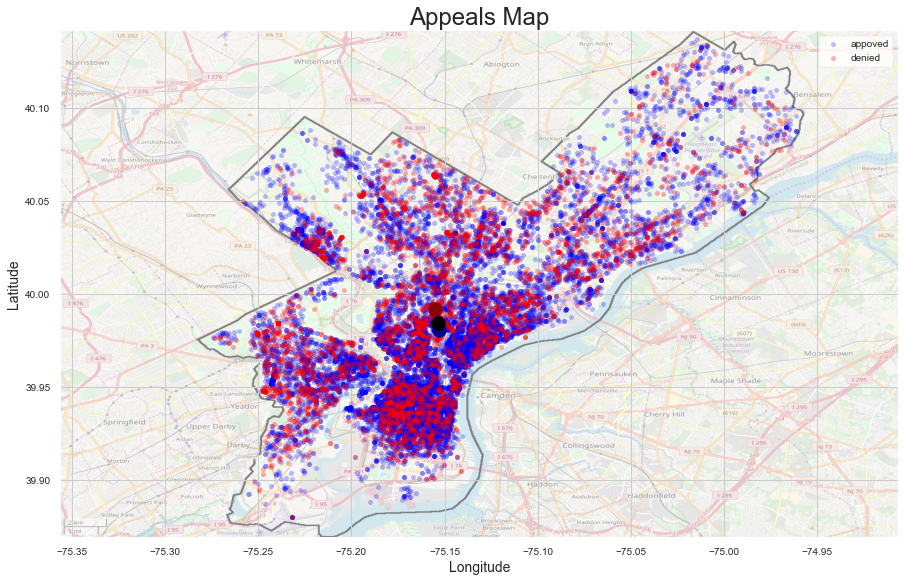

In [74]:
import numpy as np
import matplotlib.image as mpimg
philadelphia_img=mpimg.imread('images/Street_map_of_Philadelphia_and_surrounding_area.png')

plt.axes
plt.figure(figsize=(15,15))
plt.title('Appeals Map', size=24)
plt.rc('font', size=24)

plt.imshow(philadelphia_img, extent=[-75.356, -74.9066, 39.8694, 40.1414], alpha=0.5)

dfscat = df[df['decision'] == 'approved']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'appoved', s=20, alpha=0.25, c='blue')

dfscat = df[df['decision'] == 'denied']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'denied', s=20, alpha=0.3, c='red')

plt.scatter(centers.loc['denied']['lng'], centers.loc['denied']['lat'], c='darkred', s=200, alpha=1)
plt.scatter(centers.loc['approved']['lng'], centers.loc['approved']['lat'], c='darkblue', s=200, alpha=1)
plt.scatter(centers.loc['general']['lng'], centers.loc['general']['lat'], c='black', s=200, alpha=1)

plt.grid('on')
plt.legend()
plt.rc('font', size=18)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.savefig('images/appeal_map.png',bbox_inches='tight')
plt.show() 

<AxesSubplot:>

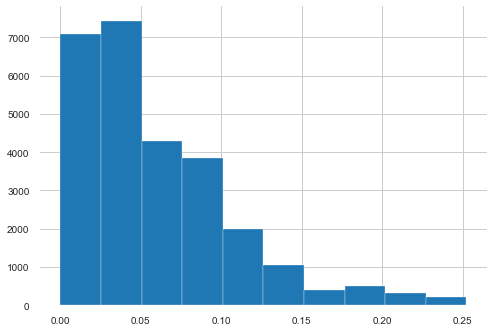

In [75]:
#Distance from CC
df['fromCC'].hist()

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

#### Appeal Grounds
[(back to the top)](#top)

In [76]:
df['appealgrounds'] = df['appealgrounds'].str.lower()

In [77]:
#remove punctuation
df['appealgrounds'] = df['appealgrounds'].str.replace(f'[{string.punctuation}]', '')
df['appealgrounds'] = df['appealgrounds'].str.replace('\d+', '')

In [78]:
df[df['appealgrounds'].isna()]['appealgrounds'].shape

(15,)

In [79]:
#dropping 14 records that have null for appealgrounds
df['appealgrounds'].fillna('',inplace=True)

In [80]:
df['appealgrounds'].head(10)

0    permit for the erection of a roof deck less than  above the roof level with  high railing with access to the roof deck through the existing penthouse with existing mechanical equipment maximum  ft high and proposed conversion of the existing five  story structure with cellar as follows cellar  residential trash storage area electrical room elevator mechanical room and remainder of the cellar to remain vacant st floor  two  vacant spaces with uses as permitted in c commercial district nd thru th floors   total eight  dwelling units
1                                           permit for legalization of the erection of four  story exterior stair open sided with roof proposed conversion of the existing four  story structure to four  artist studios with artists to reside on the premises to include display of artists work including viewing and special viewing events and retail sales of artists work and proposed four  accessory parking spaces including one  handicap space and for the ere

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

Jump down to  
[Testing Models with TFIDF classifier results](#Testing-Models-with-TFIDF-classifier-results)

### myMetrics Function for model testing
[(back to the top)](#top)

In [81]:
# Create metrics function to check metrics for different models

def myMetrics(model=None, sample=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None):
    
    hypertablerow={}
    hypertablerow['model'] = model.__class__.__name__
    #print("Model:", model.__class__.__name__)
    hypertablerow['sample'] = sample + ' sample'
    hypertablerow['features'] = features

    X_train_temp = X_train[features]
    X_test_temp = X_test[features]  
    #print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    #print("y_pred_test.value_counts:", pd.Series(y_pred_test).value_counts())
    #print("y_pred_train.value_counts:", pd.Series(y_pred_train).value_counts())

    # F1 score
    hypertablerow['f1_score_test'] = metrics.f1_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('f1_score_test', hypertablerow['f1_score_test'])
    hypertablerow['f1_score_train'] = metrics.f1_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('f1_score_train', hypertablerow['f1_score_train'])
    # Accuracy
    hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
    #print('accuracy_test', hypertablerow['accuracy_test'])
    hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
    #print('accuracy_train', hypertablerow['accuracy_train'])
    # Precision
    hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    # Recall
    hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')

    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
    return hypertablerow

### Create "dummy" variables for applicationtype column

In [82]:
# Create "dummy" variables for applicationtype columns
df = pd.concat([df, pd.get_dummies(df['applicationtype'])], axis=1)
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'lawyer', 'decisionsv',
       'provFlag', 'from_approved_center', 'from_approved_center_Sq',
       'from_denied_center', 'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'Board of Building Standards', 'L&I Review Board 

I am planning to oversample and undersample the original dataset.
To be able to compare the results of the original dataset with oversample and undersample I am creating two sets for the X and y as well as the list of sample names.

In [83]:
X = {}
y = {}
samples = ['original', 'under', 'over']

In [84]:
# Declare an explanatory variable, and assign some data to it 
X['original'] = df.drop(['decision'], axis=1)

# Declare a response variable, the decision column of the df 
y['original'] = df['decision'] 

In [85]:
X['original'].columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'meetingresult',
       'proviso', 'decisiondate', 'systemofrecord', 'geocode_x', 'geocode_y',
       'lat', 'lng', 'lawyer', 'decisionsv', 'provFlag',
       'from_approved_center', 'from_approved_center_Sq', 'from_denied_center',
       'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'Board of Building Standards', 'L&I Review Board Codes',
    

### Pre-processing and Test/Train Split
[(back to the top)](#top)

In [86]:
#UnderSampling

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
rus.fit(X['original'], y['original'])

X['under'], y['under'] = rus.fit_resample(X['original'], y['original'])

In [87]:
#OverSampling

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X['original'], y['original'])

X['over'], y['over'] = ros.fit_resample(X['original'], y['original'])

In [88]:
# import the preprocessing package
from sklearn import preprocessing
X_train = {}
X_test = {}
y_train = {}
y_test = {}

# Call the train_test_split() function
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
for sample in samples:
    X_train[sample], X_test[sample], y_train[sample], y_test[sample] = \
    train_test_split(X[sample], y[sample], test_size=0.25, random_state=1)

In [89]:
for sample in samples:
    print('\n' + sample + ' sample')
    print('X_train.shape',X_train[sample].shape)
    print('X_test.shape',X_test[sample].shape)
    print('y_train.size', y_train[sample].size)
    print('y_test.size', y_test[sample].size)
    print('y_train.value_counts',y_train[sample].value_counts())
    print('y_train.describe', y_test[sample].value_counts())


original sample
X_train.shape (20382, 56)
X_test.shape (6794, 56)
y_train.size 20382
y_test.size 6794
y_train.value_counts approved    12700
other        4601
denied       3081
Name: decision, dtype: int64
y_train.describe approved    4183
other       1537
denied      1074
Name: decision, dtype: int64

under sample
X_train.shape (9348, 56)
X_test.shape (3117, 56)
y_train.size 9348
y_test.size 3117
y_train.value_counts denied      3141
other       3112
approved    3095
Name: decision, dtype: int64
y_train.describe approved    1060
other       1043
denied      1014
Name: decision, dtype: int64

over sample
X_train.shape (37986, 56)
X_test.shape (12663, 56)
y_train.size 37986
y_test.size 12663
y_train.value_counts approved    12680
other       12660
denied      12646
Name: decision, dtype: int64
y_train.describe denied      4237
other       4223
approved    4203
Name: decision, dtype: int64


### Testing LinearSVC model

In [90]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#model = GaussianNB()
#model = KNeighborsClassifier(n_neighbors=10)
model = svm.LinearSVC() # Linear Kernel
#model = svm.SVC(kernel='poly') # Linear Kernel
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    print('y_true_test.value_counts()', y_true_test.value_counts())

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'fromCC']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4183
other       1537
denied      1074
Name: decision, dtype: int64
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    5365
other       1429
dtype: int64
y_pred_train.describe: approved    16223
other        4159
dtype: int64
Test Accuracy 0.7396231969384751
Train Accuracy 0.7474732607202433
y_true_test.value_counts() approved    1060
other       1043
denied      1014
Name: decision, dtype: int64
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    2043
other       1074
dtype: int64
y_pred_train.describe: approved    5960
other       3388
dtype: int64
Test Accuracy 0.5155598331729226
Train Accuracy 0.5135857937526743
y_true_test.value_counts() denied      4237
other       4223
approved    4203
Na

In [91]:
model = svm.LinearSVC() # Linear Kernel
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

y_true_train = y_train['over']
y_true_test = y_test['over']

X_train_temp = X_train['over'][features]
X_test_temp = X_test['over'][features]  

#    print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_pred_test.describe: denied      10233
approved     2021
other         409
dtype: int64
y_pred_train.describe: denied      30707
approved     6113
other        1166
dtype: int64
Test Accuracy 0.3986417120745479
Train Accuracy 0.40185857947664927


In [92]:
from sklearn.metrics import confusion_matrix

In [93]:
np.set_printoptions(precision=2)

cm = confusion_matrix(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)


In [94]:
cm

array([[1168, 3035,    0],
       [ 406, 3651,  180],
       [ 447, 3547,  229]], dtype=int64)

In [95]:
y_true_test.value_counts()

denied      4237
other       4223
approved    4203
Name: decision, dtype: int64

In [96]:
pd.Series(y_pred_test).value_counts()

denied      10233
approved     2021
other         409
dtype: int64

It appears that Linear SVC model even when oversampled returns very poor test result - no values in "denied" class.

### Testing KNeighborsClassifier model

In [97]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier(n_neighbors=10)
#model = svm.LinearSVC() # Linear Kernel
model = svm.SVC(kernel='poly', degree=2) # Poy Kernel - takes VERY LONG time
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    print('y_true_test.value_counts()', y_true_test.value_counts())

    print("Model:", model.__class__.__name__)

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'fromCC']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4183
other       1537
denied      1074
Name: decision, dtype: int64
Model: SVC
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    5365
other       1429
dtype: int64
y_pred_train.describe: approved    16223
other        4159
dtype: int64
Test Accuracy 0.7396231969384751
Train Accuracy 0.7474732607202433
y_true_test.value_counts() approved    1060
other       1043
denied      1014
Name: decision, dtype: int64
Model: SVC
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    2043
other       1074
dtype: int64
y_pred_train.describe: approved    5960
other       3388
dtype: int64
Test Accuracy 0.5155598331729226
Train Accuracy 0.5135857937526743
y_true_test.value_counts() denied      4237
other       42

### Confusion Matrix

In [98]:
y_true_test.value_counts()

denied      4237
other       4223
approved    4203
Name: decision, dtype: int64

Confusion matrix, without normalization
[[4162    0   41]
 [4195    0   42]
 [4181    0   42]]
Normalized confusion matrix
[[0.99 0.   0.01]
 [0.99 0.   0.01]
 [0.99 0.   0.01]]


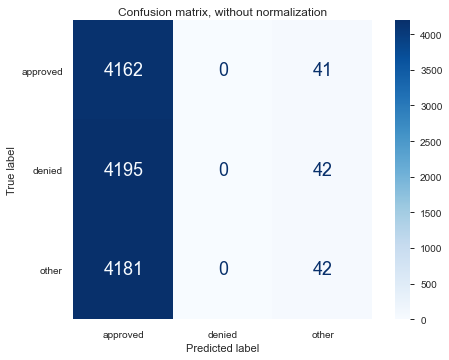

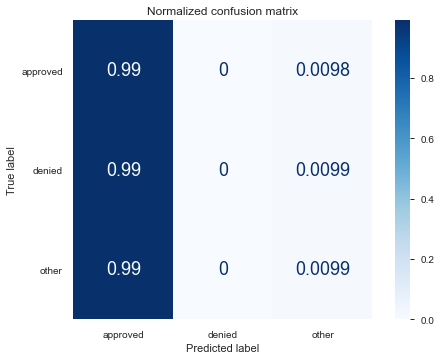

In [99]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test_temp, y_true_test,
#                                 display_labels=y_true_test.sort_values().unique(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


### LogisticRegression
[(back to the top)](#top)

In [100]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [101]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [102]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [103]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [104]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [105]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [106]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [107]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [108]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### KNeighborsClassifier Model

In [109]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [110]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [111]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [112]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [113]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [114]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [115]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [116]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [117]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Gaussian Naive Bayes Model

In [118]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [119]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [120]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [121]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [122]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [123]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Random Forrest Classifier Model

In [124]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification
model = RandomForestClassifier(max_depth= 5, random_state= 1234)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [125]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth= 5, random_state= 1234)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [126]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [127]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Decision Tree Classifier

In [128]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion="gini", max_depth = 5, random_state = 1234)

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [129]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

## Final Hypertable
[(back to the top)](#top)

In [130]:
pd.DataFrame(hypertable).to_csv('hypertable.csv')
dfhypertable = pd.DataFrame(hypertable).sort_values('precision_test')
pd.set_option('display.max_colwidth', -1)
pd.set_option("max_rows", None)
dfhypertable.round(3).sort_values('f1_score_test', ascending=False)

,model,sample,features,f1_score_test,f1_score_train,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train
48,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.696,0.736,0.732,0.767,0.695,0.746,0.732,0.767
42,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, from_approved_center, from_denied_center]",0.696,0.736,0.732,0.767,0.695,0.746,0.732,0.767
45,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.695,0.737,0.731,0.767,0.693,0.746,0.731,0.767
36,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center]",0.694,0.739,0.730,0.769,0.692,0.749,0.730,0.769
39,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.694,0.738,0.731,0.768,0.692,0.747,0.731,0.768
51,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center, from_approved_center_Sq, from_denied_center_Sq]",0.691,0.733,0.729,0.765,0.689,0.744,0.729,0.765
33,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC]",0.689,0.733,0.729,0.766,0.686,0.745,0.729,0.766
87,DecisionTreeClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.679,0.688,0.744,0.752,0.754,0.757,0.744,0.752
21,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.678,0.683,0.724,0.729,0.690,0.703,0.724,0.729
81,RandomForestClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center]",0.677,0.687,0.742,0.751,0.725,0.748,0.742,0.751


## Testing Models with TFIDF classifier results
[(back to the top)](#top)

##### Configure and run TFIDF

In [131]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), 
                    max_df=0.75, min_df=15)
tfidfmatrix = vectorizer.fit_transform(df['appealgrounds'])
type(tfidfmatrix)

scipy.sparse.csr.csr_matrix

In [132]:
#tfidfmatrix = tfidfmatrix.todense()
tfidfmatrix = tfidfmatrix.toarray()
type(tfidfmatrix)

numpy.ndarray

In [133]:
type(vectorizer.get_feature_names())

list

In [134]:
df_tfidf = pd.DataFrame(tfidfmatrix, columns=vectorizer.get_feature_names())
df_tfidf.head()

,ab,abandoned,able,abutting,ac,acc,acc parking,acc parking spaces,acc storage,access,...,zoning district use,zoning lot,zoning lot treatment,zoning lots,zoning permit,zoning purposes,zoning purposes restrictive,zoning use,zoninguse,zoninguse permit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
df_tfidf.shape

(27176, 8159)

In [136]:
final_features = ['decision', 'Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', \
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', \
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']

In [137]:
df_final_features = df[final_features].rename(columns={'decision':'_decision_', 'lawyer':'_lawyer_'})
df_final_features.reset_index(inplace=True)
df_final_features.columns

Index(['index', '_decision_', 'Board of Building Standards',
       'L&I Review Board Codes', 'Zoning Board of Adjustment', '_lawyer_',
       'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
       'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq'],
      dtype='object')

In [138]:
df_final_features.shape

(27176, 15)

In [139]:
df_tfidf.shape
#df_tfidf.reset_index(inplace=True)

(27176, 8159)

In [140]:
appealgrounds_df = pd.concat([df_final_features, df_tfidf], axis=1)
appealgrounds_df.shape

(27176, 8174)

In [141]:
appealgrounds_df.columns[:20]

Index(['index', '_decision_', 'Board of Building Standards',
       'L&I Review Board Codes', 'Zoning Board of Adjustment', '_lawyer_',
       'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
       'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 'ab',
       'abandoned', 'able', 'abutting', 'ac'],
      dtype='object')

In [142]:
onerow = appealgrounds_df.iloc[150]
onerow = onerow[(onerow.notna())]
type(onerow)

pandas.core.series.Series

In [143]:
onerow[onerow != 0]

index                         154       
_decision_                    approved  
Zoning Board of Adjustment    1         
_lawyer_                      1         
fromCC                        0.0720726 
from_general_center           115.16    
fromSouth                     0.100533  
fromWest                      0.0873092 
fromNE                        0.0987938 
fromCC_Sq                     0.00519447
fromSouth_Sq                  0.010107  
fromWest_Sq                   0.00762289
fromNE_Sq                     0.00976021
dwelling                      0.292785  
family                        0.298007  
family dwelling               0.334171  
permit                        0.200845  
permit family                 0.57387   
permit family dwelling        0.58663   
Name: 150, dtype: object

In [144]:
df['appealgrounds'].iloc[150]

'permit is for a three family dwelling'

##### Testing models with TFIDF vectorizer results

In [145]:
# Create metrics function to check metrics for different models

def myMetrics2(model=None, sample=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None):
    
    hypertablerow={}
    hypertablerow['model'] = model.__class__.__name__
    hypertablerow['sample'] = sample
    hypertablerow['features'] = features

    X_train_temp = X_train
    X_test_temp = X_test
    #print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    #print("y_pred_test.value_counts:", pd.Series(y_pred_test).value_counts())
    #print("y_pred_train.value_counts:", pd.Series(y_pred_train).value_counts())

    # F1 score
    hypertablerow['f1_score_test'] = metrics.f1_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('f1_score_test', hypertablerow['f1_score_test'])
    hypertablerow['f1_score_train'] = metrics.f1_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('f1_score_train', hypertablerow['f1_score_train'])
    # Accuracy
    hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
    #print('accuracy_test', hypertablerow['accuracy_test'])
    hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
    #print('accuracy_train', hypertablerow['accuracy_train'])
    # Precision
    hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    # Recall
    hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')

    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
    return hypertablerow

In [146]:
appealgrounds_df.fillna(value=0, inplace=True)

In [147]:
appealgrounds_df.shape

(27176, 8174)

In [148]:
# Declare a response variable, the decision column of the df 
y = appealgrounds_df['_decision_'] 

# Declare an explanatory variable, and assign some data to it 
X = appealgrounds_df.drop(['_decision_'], axis = 1)

In [149]:
onerow = X.iloc[150]
onerow = onerow[(onerow.notna())]
onerow[onerow != 0]

index                         154.000000
Zoning Board of Adjustment    1.000000  
_lawyer_                      1.000000  
fromCC                        0.072073  
from_general_center           115.160429
fromSouth                     0.100533  
fromWest                      0.087309  
fromNE                        0.098794  
fromCC_Sq                     0.005194  
fromSouth_Sq                  0.010107  
fromWest_Sq                   0.007623  
fromNE_Sq                     0.009760  
dwelling                      0.292785  
family                        0.298007  
family dwelling               0.334171  
permit                        0.200845  
permit family                 0.573870  
permit family dwelling        0.586630  
Name: 150, dtype: float64

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [151]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']


In [152]:
model = KNeighborsClassifier(n_neighbors=10)

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [153]:
model = tree.DecisionTreeClassifier(criterion="gini", max_depth = 5, random_state = 1234)

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [154]:
model = RandomForestClassifier(max_depth= 10, random_state= 1234)

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [155]:
model = GaussianNB()

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [156]:
model = LogisticRegression(class_weight='balanced')

hypertablerow = myMetrics2(model=model,sample='TFIDF Vectorizer',features=features, 
                          X_train=X_train, y_true_train=y_train, 
                          X_test=X_test, y_true_test=y_test)

In [157]:
pd.DataFrame(hypertable).to_csv('hypertable.csv')
dfhypertable = pd.DataFrame(hypertable).sort_values('precision_test')
pd.set_option('display.max_colwidth', -1)
pd.set_option("max_rows", None)
dfhypertable.round(3).sort_values('f1_score_test', ascending=False)

,model,sample,features,f1_score_test,f1_score_train,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train
48,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.696,0.736,0.732,0.767,0.695,0.746,0.732,0.767
42,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, from_approved_center, from_denied_center]",0.696,0.736,0.732,0.767,0.695,0.746,0.732,0.767
45,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.695,0.737,0.731,0.767,0.693,0.746,0.731,0.767
36,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center]",0.694,0.739,0.730,0.769,0.692,0.749,0.730,0.769
39,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.694,0.738,0.731,0.768,0.692,0.747,0.731,0.768
51,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center, from_approved_center_Sq, from_denied_center_Sq]",0.691,0.733,0.729,0.765,0.689,0.744,0.729,0.765
33,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC]",0.689,0.733,0.729,0.766,0.686,0.745,0.729,0.766
91,DecisionTreeClassifier,TFIDF Vectorizer,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.689,0.706,0.746,0.758,0.719,0.740,0.746,0.758
87,DecisionTreeClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.679,0.688,0.744,0.752,0.754,0.757,0.744,0.752
21,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.678,0.683,0.724,0.729,0.690,0.703,0.724,0.729


Back to  
[Configure and run TFIDF](#Configure-and-run-TFIDF)